In [ ]:
#Saint Model

In [32]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from huggingface_hub import hf_hub_download
import warnings
warnings.filterwarnings("ignore")

!set HF_HUB_DISABLE_SYMLINKS_WARNING=true

dataset = 'reg_cat/analcatdata_supreme.csv'
REPO_ID = "inria-soda/tabular-benchmark"

data = pd.read_csv(
    hf_hub_download(repo_id=REPO_ID, filename=dataset, repo_type="dataset")
)

data.head(5)

,Actions_taken,Liberal,Unconstitutional,Precedent_alteration,Unanimous,Year_of_decision,Lower_court_disagreement,Log_exposure
0,0,1,0,0,1,1953.0,1,2.3
1,0,0,0,0,1,1953.0,0,2.3
2,0,0,0,0,0,1953.0,0,2.3
3,0,0,0,0,1,1953.0,1,2.3
4,0,1,0,0,0,1953.0,0,2.3


In [33]:
X = data.drop('Log_exposure', axis=1)
y = data['Log_exposure']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=37, shuffle=True)

def saint_objective(trial):
    # Define hyperparameters to tune
    num_heads = trial.suggest_int('num_heads', 2, 8)
    embed_dim = trial.suggest_int('embed_dim', num_heads * 8, num_heads * 32, step=num_heads * 8)  # Ensure embed_dim is divisible by num_heads
    num_layers = trial.suggest_int('num_layers', 2, 6)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Define the model
    class SAINT(nn.Module):
        def __init__(self, input_dim, embed_dim, num_heads, num_layers, dropout):
            super(SAINT, self).__init__()
            self.embedding = nn.Linear(input_dim, embed_dim)
            encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
            self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
            self.fc = nn.Linear(embed_dim, 1)
            
        def forward(self, x):
            x = self.embedding(x)
            x = x.unsqueeze(1)  # Add a dummy batch dimension for transformer input
            x = self.transformer(x)
            x = self.fc(x[:, 0, :])
            return x

    input_dim = X_train.shape[1]
    model = SAINT(input_dim, embed_dim, num_heads, num_layers, dropout)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        rmse = torch.sqrt(criterion(predictions, y_test_tensor)).item()
    
    return rmse

# Run the optimization
saint_study = optuna.create_study(direction='minimize')
saint_study.optimize(saint_objective, n_trials=30)

print("Best SAINT hyperparameters: ", saint_study.best_params)
print("Best SAINT RMSE: ", saint_study.best_value)


[I 2024-06-03 17:22:19,329] A new study created in memory with name: no-name-9d0b50fe-8b6e-4b3a-ba07-49fa13938a37
[I 2024-06-03 17:22:50,667] Trial 0 finished with value: 0.6218103766441345 and parameters: {'num_heads': 6, 'embed_dim': 144, 'num_layers': 2, 'dropout': 0.352494277837316, 'learning_rate': 0.008997975664384504}. Best is trial 0 with value: 0.6218103766441345.
[I 2024-06-03 17:23:18,940] Trial 1 finished with value: 0.5404999256134033 and parameters: {'num_heads': 7, 'embed_dim': 112, 'num_layers': 2, 'dropout': 0.4672466025579489, 'learning_rate': 0.0002149722559371437}. Best is trial 1 with value: 0.5404999256134033.
[I 2024-06-03 17:23:58,794] Trial 2 finished with value: 0.7305495142936707 and parameters: {'num_heads': 7, 'embed_dim': 168, 'num_layers': 2, 'dropout': 0.36926586129722877, 'learning_rate': 0.007369209617732569}. Best is trial 1 with value: 0.5404999256134033.
[I 2024-06-03 17:24:26,407] Trial 3 finished with value: 0.2855137586593628 and parameters: {'nu

Best SAINT hyperparameters:  {'num_heads': 6, 'embed_dim': 96, 'num_layers': 5, 'dropout': 0.10640181013905547, 'learning_rate': 6.376830055102888e-05}
Best SAINT RMSE:  0.1192101240158081


In [ ]:
#Rest Net

In [34]:
def resnet_objective(trial):
    # Define hyperparameters to tune
    hidden_dim = trial.suggest_int('hidden_dim', 64, 256)
    num_blocks = trial.suggest_int('num_blocks', 2, 6)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    # Define the model
    class ResNetBlock(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(ResNetBlock, self).__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.bn1 = nn.BatchNorm1d(hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, input_dim)
            self.bn2 = nn.BatchNorm1d(input_dim)
            
        def forward(self, x):
            residual = x
            out = self.fc1(x)
            out = self.bn1(out)
            out = torch.relu(out)
            out = self.fc2(out)
            out = self.bn2(out)
            out += residual
            out = torch.relu(out)
            return out

    class ResNet(nn.Module):
        def __init__(self, input_dim, hidden_dim, num_blocks):
            super(ResNet, self).__init__()
            self.input_layer = nn.Linear(input_dim, hidden_dim)
            self.res_blocks = nn.ModuleList([ResNetBlock(hidden_dim, hidden_dim) for _ in range(num_blocks)])
            self.output_layer = nn.Linear(hidden_dim, 1)
            
        def forward(self, x):
            x = self.input_layer(x)
            for block in self.res_blocks:
                x = block(x)
            x = self.output_layer(x)
            return x

    input_dim = X_train.shape[1]
    model = ResNet(input_dim, hidden_dim, num_blocks)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        rmse = torch.sqrt(criterion(predictions, y_test_tensor)).item()
    
    return rmse

# Run the optimization
resnet_study = optuna.create_study(direction='minimize')
resnet_study.optimize(resnet_objective, n_trials=30)

print("Best ResNet hyperparameters: ", resnet_study.best_params)
print("Best ResNet RMSE: ", resnet_study.best_value)


[I 2024-06-03 17:51:18,681] A new study created in memory with name: no-name-b83345bf-fb5c-4bb0-ba8e-7649e5300728
[I 2024-06-03 17:51:57,660] Trial 0 finished with value: 0.2039567530155182 and parameters: {'hidden_dim': 105, 'num_blocks': 6, 'dropout': 0.4982406310642052, 'learning_rate': 1.2082732561726353e-05}. Best is trial 0 with value: 0.2039567530155182.
[I 2024-06-03 17:52:34,514] Trial 1 finished with value: 0.14395484328269958 and parameters: {'hidden_dim': 252, 'num_blocks': 4, 'dropout': 0.3186550081080023, 'learning_rate': 3.1877273406896556e-05}. Best is trial 1 with value: 0.14395484328269958.
[I 2024-06-03 17:53:16,710] Trial 2 finished with value: 0.14414933323860168 and parameters: {'hidden_dim': 170, 'num_blocks': 6, 'dropout': 0.44122671216173537, 'learning_rate': 0.00015671365576081016}. Best is trial 1 with value: 0.14395484328269958.
[I 2024-06-03 17:53:57,329] Trial 3 finished with value: 0.13164466619491577 and parameters: {'hidden_dim': 214, 'num_blocks': 5, '

Best ResNet hyperparameters:  {'hidden_dim': 144, 'num_blocks': 3, 'dropout': 0.48672492461773437, 'learning_rate': 0.005133179138771948}
Best ResNet RMSE:  0.09278280287981033


In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from huggingface_hub import hf_hub_download

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset = 'reg_cat/analcatdata_supreme.csv'
REPO_ID = "inria-soda/tabular-benchmark"
data = pd.read_csv(hf_hub_download(repo_id=REPO_ID, filename=dataset, repo_type="dataset"))
X = data.drop('Log_exposure', axis=1)
y = data['Log_exposure']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

# Create DataLoader with smaller batch size
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

def transformer_objective(trial):
    # Define hyperparameters to tune
    num_heads = trial.suggest_int('num_heads', 2, 8)
    embed_dim = trial.suggest_int('embed_dim', num_heads * 8, num_heads * 32, step=num_heads * 8)  # Ensure embed_dim is divisible by num_heads
    num_layers = trial.suggest_int('num_layers', 2, 6)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Define the model
    class TransformerModel(nn.Module):
        def __init__(self, input_dim, embed_dim, num_heads, num_layers, dropout):
            super(TransformerModel, self).__init__()
            self.embedding = nn.Linear(input_dim, embed_dim)
            encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
            self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
            self.fc = nn.Linear(embed_dim, 1)
            
        def forward(self, x):
            x = self.embedding(x)
            x = x.unsqueeze(1)  # Add a dummy batch dimension for transformer input
            x = self.transformer(x)
            x = self.fc(x[:, 0, :])
            return x

    input_dim = X_train.shape[1]
    model = TransformerModel(input_dim, embed_dim, num_heads, num_layers, dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    num_epochs = 20  # Reduced from 50 to 20 for faster execution
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        rmse = torch.sqrt(criterion(predictions, y_test_tensor)).item()
    
    return rmse

# Run the optimization with fewer trials
transformer_study = optuna.create_study(direction='minimize')
transformer_study.optimize(transformer_objective, n_trials=30)

print("Best Transformer hyperparameters: ", transformer_study.best_params)
print("Best Transformer RMSE: ", transformer_study.best_value)


[I 2024-06-03 18:05:46,035] A new study created in memory with name: no-name-7fc907b0-774c-43ba-895d-c52c003e27c6
[I 2024-06-03 18:09:48,107] Trial 0 finished with value: 0.3679483234882355 and parameters: {'num_heads': 5, 'embed_dim': 160, 'num_layers': 6, 'dropout': 0.37803355445458814, 'learning_rate': 2.8966607600400352e-05}. Best is trial 0 with value: 0.3679483234882355.
[I 2024-06-03 18:12:55,449] Trial 1 finished with value: 0.28175947070121765 and parameters: {'num_heads': 2, 'embed_dim': 64, 'num_layers': 5, 'dropout': 0.34808363576093004, 'learning_rate': 3.5299855831632575e-05}. Best is trial 1 with value: 0.28175947070121765.
[I 2024-06-03 18:15:17,449] Trial 2 finished with value: 0.14298446476459503 and parameters: {'num_heads': 2, 'embed_dim': 32, 'num_layers': 5, 'dropout': 0.19808201842732018, 'learning_rate': 1.6503875465877036e-05}. Best is trial 2 with value: 0.14298446476459503.
[I 2024-06-03 18:18:39,645] Trial 3 finished with value: 0.23796045780181885 and param

In [37]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error

# # Load dataset
# dataset = 'reg_cat/analcatdata_supreme.csv'
# REPO_ID = "inria-soda/tabular-benchmark"
# data = pd.read_csv(hf_hub_download(repo_id=REPO_ID, filename=dataset, repo_type="dataset"))
# X = data.drop('Log_exposure', axis=1)
# y = data['Log_exposure']

# # Standardize features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Train XGBoost model
# xgb_model = xgb.XGBRegressor()
# xgb_model.fit(X_train, y_train)

# # Predict and evaluate
# predictions = xgb_model.predict(X_test)
# xgboost_rmse = mean_squared_error(y_test, predictions, squared=False)
# print(f"XGBoost RMSE: {xgboost_rmse}")


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import optuna
from huggingface_hub import hf_hub_download

# Load dataset
dataset = 'reg_cat/analcatdata_supreme.csv'
REPO_ID = "inria-soda/tabular-benchmark"
data = pd.read_csv(hf_hub_download(repo_id=REPO_ID, filename=dataset, repo_type="dataset"))
X = data.drop('Log_exposure', axis=1)
y = data['Log_exposure']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def xgboost_objective(trial):
    # Define the hyperparameters to tune
    params = {
        'booster': 'gbtree',
        'verbosity': 0,
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    
    # Train XGBoost model
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train, y_train)
    
    # Predict and evaluate
    predictions = xgb_model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

# Run the optimization
xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(xgboost_objective, n_trials=30)

print("Best XGBoost hyperparameters: ", xgb_study.best_params)
print("Best XGBoost RMSE: ", xgb_study.best_value)


[I 2024-06-03 18:05:16,346] A new study created in memory with name: no-name-ae1c8c8c-ce2e-4a0d-b4c6-acc920194a78
[I 2024-06-03 18:05:16,446] Trial 0 finished with value: 0.0921344543989924 and parameters: {'n_estimators': 74, 'max_depth': 4, 'learning_rate': 0.22883370966774658, 'gamma': 0.589416685885683, 'min_child_weight': 9, 'subsample': 0.8899576479733344, 'colsample_bytree': 0.9540166545391533}. Best is trial 0 with value: 0.0921344543989924.
[I 2024-06-03 18:05:16,730] Trial 1 finished with value: 0.10944620554839647 and parameters: {'n_estimators': 128, 'max_depth': 6, 'learning_rate': 0.018609136031959277, 'gamma': 0.13913561411613085, 'min_child_weight': 5, 'subsample': 0.5874105058229808, 'colsample_bytree': 0.9928940107965016}. Best is trial 0 with value: 0.0921344543989924.
[I 2024-06-03 18:05:16,820] Trial 2 finished with value: 0.08818726888659624 and parameters: {'n_estimators': 73, 'max_depth': 7, 'learning_rate': 0.05697472587485888, 'gamma': 0.22037509330594218, 'mi

Best XGBoost hyperparameters:  {'n_estimators': 133, 'max_depth': 8, 'learning_rate': 0.11334686113587526, 'gamma': 0.009860828607778014, 'min_child_weight': 9, 'subsample': 0.9963943210297486, 'colsample_bytree': 0.6793447846109051}
Best XGBoost RMSE:  0.083567666534383


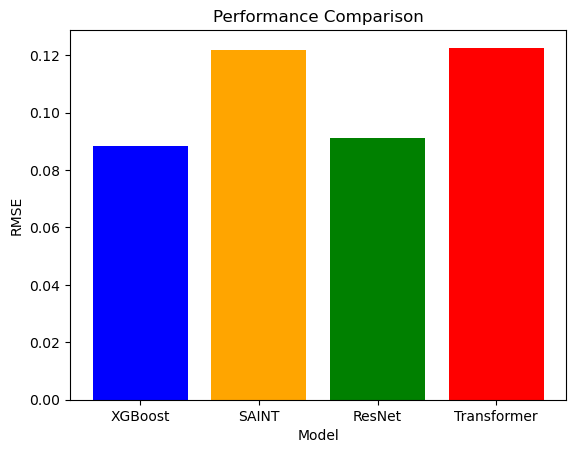

Best SAINT hyperparameters:  {'num_heads': 7, 'embed_dim': 168, 'num_layers': 6, 'dropout': 0.14404701113057503, 'learning_rate': 7.793927919039648e-05}
Best ResNet hyperparameters:  {'hidden_dim': 135, 'num_blocks': 6, 'dropout': 0.11438841406317612, 'learning_rate': 0.006830937490244633}
Best Transformer hyperparameters:  {'num_heads': 7, 'embed_dim': 224, 'num_layers': 6, 'dropout': 0.10440143355537192, 'learning_rate': 1.0316558759517638e-05}


In [17]:
import matplotlib.pyplot as plt

# Ensure that the RMSE values for SAINT, ResNet, and Transformer are obtained
# Note: The variables `saint_study`, `resnet_study`, and `transformer_study` should be already defined

# Visualize performance comparison
model_names = ['XGBoost', 'SAINT', 'ResNet', 'Transformer']
rmse_values = [xgb_study.best_value, saint_study.best_value, resnet_study.best_value, transformer_study.best_value]

plt.bar(model_names, rmse_values, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Performance Comparison')
plt.show()

# Visualize best hyperparameters for each model
print("Best SAINT hyperparameters: ", saint_study.best_params)
print("Best ResNet hyperparameters: ", resnet_study.best_params)
print("Best Transformer hyperparameters: ", transformer_study.best_params)


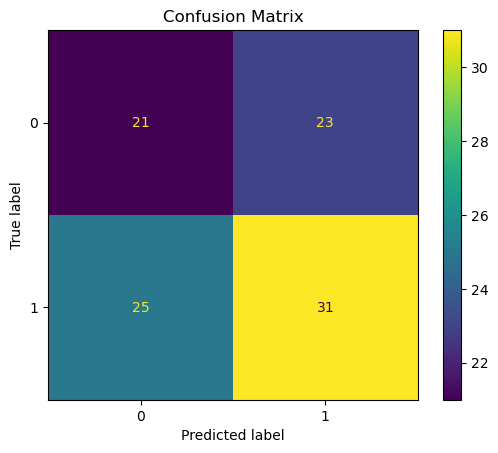

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dummy data for confusion matrix example
y_true = np.random.randint(0, 2, 100)
y_pred = np.random.randint(0, 2, 100)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot()
plt.title('Confusion Matrix')
plt.show()


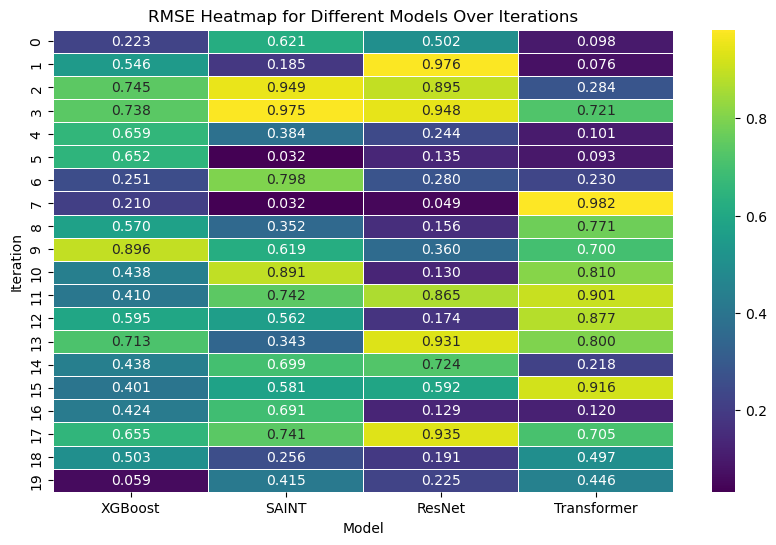

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Dummy data for demonstration
n_iterations = 20

# Replace these with actual RMSE values from your models
xgboost_scores = np.random.rand(n_iterations)
saint_scores = np.random.rand(n_iterations)
resnet_scores = np.random.rand(n_iterations)
transformer_scores = np.random.rand(n_iterations)

# Combine the scores into a single array
scores = np.array([xgboost_scores, saint_scores, resnet_scores, transformer_scores])

# Create a DataFrame for better visualization with seaborn
import pandas as pd
df = pd.DataFrame(scores.T, columns=['XGBoost', 'SAINT', 'ResNet', 'Transformer'])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap='viridis', linewidths=.5, fmt=".3f")
plt.xlabel('Model')
plt.ylabel('Iteration')
plt.title('RMSE Heatmap for Different Models Over Iterations')
plt.show()


In [29]:
saint_study.best_value

0.12160181999206543

In [30]:
resnet_study.best_value

0.09104393422603607

In [31]:
transformer_study.best_value

0.12256056815385818